### Introduction

This Jupyter Notebook can be divided into three parts: (1) a single case to demonstrate the entire Upbeat pipeline, (2) a small-scale test to show the effectiveness of Upbeat, and (3) the evaluation presented in our paper.

The complete experiment in our paper included more test cases and ran for a longer duration. However, this notebook focuses on minimal examples to explore the capabilities of Upbeat at an affordable cost.

### Instructions for Running the Notebook

1. Copy the Notebook: Please make a copy of main.ipynb.
2. Restart and Clear Output: Open the copied notebook and select "Restart & Clear Output" from the Kernel menu.
3. Run the Notebook: Press the play button to execute each cell sequentially. Ensure you wait for each cell to complete before proceeding to the next one.

**Note:** It is crucial to wait for each step to finish. Moving to the next cell prematurely may cause errors due to incomplete data processing.

### 1 A Single Case Study

#### 1.1 Generate test cases

First, we need to import necessary tools and load code segment database. 

In [1]:
import random
import ast
import os
os.chdir("../src/Generate")

from basic_operation.dict_operation import get_rest_args
from DBOperation.dboperation_sqlite import DataBaseHandle
from combine_fragment import CodeFragmentGenerator, get_contained_cons
from cons_generator.cwvp import generate_if_cons_exist
from generate import Generate
from class_for_info.fragment_info import CodeFragmentInfo

generate = Generate("../config.json")
fragment = CodeFragmentGenerator(1, "CodeFragment_CW")
frag_db = DataBaseHandle("../../data/query/corpus-v3.db")
frag_list = frag_db.selectAll("select * from CodeFragment_CW")
print("Done.")

Done.


Then, we can select a code segment from corpus. 

In [2]:
frag = random.choice(frag_list)
available_variables = ast.literal_eval(frag[2])
needful_variables = ast.literal_eval(frag[3])
print("\033[1mcontent of code segment:\033[0m\n"+frag[1]+
      "\033[1mpre-conditions:\033[0m",needful_variables,"\n\033[1mpost-conditions:\033[0m",available_variables)

content of code segment:
if Snd(r2752) == 0L or AbsL(Snd(s2752)) > denominatorBound2752 {
    let returnVar = (Snd(r2752) == 0L and AbsL(Snd(s2752)) <= denominatorBound2752)? BigFraction(-Snd(t2752) * IntAsBigInt(signB2752), Snd(s2752) * IntAsBigInt(signA2752))| BigFraction(-Fst(t2752) * IntAsBigInt(signB2752), Fst(s2752) * IntAsBigInt(signA2752));
}
let quotient2752 = Fst(r2752) / Snd(r2752);
let r_2752 = (Snd(r2752), Fst(r2752) - quotient2752 * Snd(r2752));

pre-conditions: {'signA2752': 'Int', 'signB2752': 'Int', 'r2752': '(BigInt,BigInt)', 's2752': '(BigInt,BigInt)', 't2752': '(BigInt,BigInt)', 'denominatorBound2752': 'BigInt'} 
post-conditions: {'quotient2752': "'T", 'r_2752': "'T"}


Upbeat first check whether the selected code fragment contains any constraints. If constraints are present, Upbeat generates both valid and invalid values, marking them with a comment as a flag. Next, Upbeat attempts to combine other segments with the selected code fragment. Finally, Upbeat generates all other necessary input values.

In [3]:
# Parse constraints
bool_expr_list, func_ret_list, quanternion_list, needful_args, partial_reset_stmt = \
    get_contained_cons(frag[1], needful_variables)
# print("bool_expr_list:",bool_expr_list,"func_ret_list:",func_ret_list)
if len(bool_expr_list) > 0 or len(func_ret_list) > 0:
    print("\033[94mThere exist constraints!Start to generate inputs.\033[0m")
    valid_stmt, invalid_stmt = \
        generate_if_cons_exist(bool_expr_list, func_ret_list, quanternion_list, needful_args)
    print("==valid==\n"+valid_stmt+"\n==invalid==\n"+invalid_stmt)
else:
    valid_stmt, invalid_stmt = "//no cons\n", "//no cons\n"
# If generation failed
if valid_stmt is None:
    print("\033[91m!!!Generation failed!\033[0m")
# Generate values for other variables
needful_variables = get_rest_args(needful_variables, needful_args)
this_fragment_info = CodeFragmentInfo(frag[1], available_variables,
                                      needful_variables, frag[4], 
                                      frag[5], frag[6])
combined_fragment, combined_import = fragment.generate_a_code_frag(this_fragment_info)
if combined_fragment is None:
    print("\033[91m!!!Generation failed!\033[0m")
else:
    combined_fragment = combined_fragment.replace("\n\n", "\n").replace("//no cons\n//no cons\n", "//no cons\n")
    print("\033[1mvalid_stmt:\033[0m\n"+valid_stmt+combined_fragment+\
          "\033[1minvalid_stmt:\033[0m\n"+invalid_stmt+combined_fragment)

valid_stmt:
//no cons
//no cons
mutable b5533 = -2^63;
let signB5533 = SignI(b5533);
mutable (s15533, s25533) = (1, 0);
let signA2752 = signB5533;
mutable signB2752 = 8;
mutable r2752 = (2L,-1L);
mutable s2752 = (-1L,-418L);
mutable t2752 = (848L,154L);
mutable denominatorBound2752 = 2L^63-1L;
if Snd(r2752) == 0L or AbsL(Snd(s2752)) > denominatorBound2752 {
    let returnVar = (Snd(r2752) == 0L and AbsL(Snd(s2752)) <= denominatorBound2752)? BigFraction(-Snd(t2752) * IntAsBigInt(signB2752), Snd(s2752) * IntAsBigInt(signA2752))| BigFraction(-Fst(t2752) * IntAsBigInt(signB2752), Fst(s2752) * IntAsBigInt(signA2752));
}
let quotient2752 = Fst(r2752) / Snd(r2752);
let r_2752 = (Snd(r2752), Fst(r2752) - quotient2752 * Snd(r2752));
Message($"{quotient2752}");
Message($"{r_2752}");
invalid_stmt:
//no cons
//no cons
mutable b5533 = -2^63;
let signB5533 = SignI(b5533);
mutable (s15533, s25533) = (1, 0);
let signA2752 = signB5533;
mutable signB2752 = 8;
mutable r2752 = (2L,-1L);
mutable s2752 = (-

Finally, we will insert all generated elements into the template. If there are API constraints in the relevant code segments, Upbeat will generate two test cases (one for valid inputs and another for invalid inputs). Otherwise, Upbeat will generate a single test case. 

In [4]:
valid_testcase, invalid_testcase = "", ""
# Get self_defined_callables
defined_callables = ""
for item in fragment.self_defined_callables:
    if isinstance(item, str):
        if item not in defined_callables:
            defined_callables += item
    else:
        if item.content not in defined_callables:
            defined_callables += item.content
# print("===defined_callables:\n"+defined_callables+"\n")
# Process valid test case
valid_fragment = valid_stmt+combined_fragment+partial_reset_stmt
valid_import = combined_import
valid_testcase = generate.assemble_testcase(valid_fragment, valid_import, [defined_callables])
print("\033[1m==valid_testcase==\n\033[0m",valid_testcase)
# Process invalid test case
if invalid_stmt is None or invalid_stmt == valid_stmt:
    print("\033[1m==invalid_testcase==\nSame as below.\033[0m")
else:
    invalid_fragment = invalid_stmt+combined_fragment+partial_reset_stmt
    invalid_import = combined_import
    invalid_testcase = generate.assemble_testcase(invalid_fragment, invalid_import, [defined_callables])
    print("\033[1m==invalid_testcase==\n\033[0m",invalid_testcase)

==valid_testcase==
 namespace NISLNameSpace {
    open Microsoft.Quantum.Canon;
    open Microsoft.Quantum.Logical;
    open Microsoft.Quantum.Arrays;
    open Microsoft.Quantum.Convert;
    open Microsoft.Quantum.Intrinsic;
    open Microsoft.Quantum.Diagnostics;
    open Microsoft.Quantum.Arithmetic;
    open Microsoft.Quantum.Oracles;
    open Microsoft.Quantum.Math;


    
    @EntryPoint()
    operation main() : Unit {
        //no cons
        //no cons
        mutable b5533 = -2^63;
        let signB5533 = SignI(b5533);
        mutable (s15533, s25533) = (1, 0);
        let signA2752 = signB5533;
        mutable signB2752 = 8;
        mutable r2752 = (2L,-1L);
        mutable s2752 = (-1L,-418L);
        mutable t2752 = (848L,154L);
        mutable denominatorBound2752 = 2L^63-1L;
        if Snd(r2752) == 0L or AbsL(Snd(s2752)) > denominatorBound2752 {
            let returnVar = (Snd(r2752) == 0L and AbsL(Snd(s2752)) <= denominatorBound2752)? BigFraction(-Snd(t2752) * IntAsBigI

#### 1.2 Execute test cases
The test oracles of Upbeat come from (1) language-level testing via constraints or (2) differential testing. In language-level testing, any results deviate from expected behaviors, crashed and timeouts will be served as anomalous. 

In [5]:
os.chdir("../Fuzzing")

from Fuzzing.lib.Harness import *
from Fuzzing.lib.post_processor import *
from Generate.basic_operation.file_operation import initParams

# You can also change `valid_testcase`` into `invalid_testcase` if they are different
testcase_content = valid_testcase

print("\033[1m==language-level testing==\033[0m")
print("Please wait a few seconds until you see the message 'nothing happended' or '!!!find wrong cons'.")
susp_flag = False
# Record expected behavior
if "//wrong" in testcase_content or "//invalid" in testcase_content:
    flag = 0
elif "//correct" in testcase_content or "//valid" in testcase_content:
    flag = 1
else:
    flag = -1
# Execute test case
output = execute(0, testcase_content, ["dotnet", "run"], False)
print("\033[1moutput1:\n\033[0m"+output.stdout)
# Detect anomalous
if  ((flag == 1 and output.returnCode != 0) or 
    (flag == 0 and output.returnCode == 0) or 
    output.outputClass in ["timout", "crash"]):
    print("\033[91m!!!find wrong cons\033[0m")
    susp_flag = True
else:
    print("\033[92mnothing happened\033[0m")

==language-level testing==
Please wait a few seconds until you see the message 'nothing happended' or '!!!find wrong cons'.
cmd:dotnet run
output1:
[]
-2
(-1, 0)
nothing happened


In differential testing, Upbeat will detect any inconsistency, crash, or timeout. 

**Note:** The voting scheme has filtered some simple faulty behaviors. For example, ToffoliSimulator only supports parts of basic gates, it will throw a `NotImplementedException` exception if the test cases contain unsupported callables. Upbeat does not compare this exception with other results. 

In [6]:
# differential testing activates only if language-level testing detects no anomalies
if not susp_flag and output.returnCode not in [134, 137]:
    outputs = [output]
    command_list = [["dotnet", "run", "-s", "SparseSimulator"],
                    ["dotnet", "run", "-s", "ToffoliSimulator"]]
    # execute on SparseSimulator and ToffoliSimulator
    for i, cmd in enumerate(command_list, start=2):
        tmp_output = execute(0, output.testcaseContent, cmd, False)
        outputs.append(tmp_output)
        print("\033[1moutput"+str(i)+":\n\033[0m"+tmp_output.stdout)
    # voting scheme
    vote(outputs, output.testcaseContent)
else:
    print("Already be anomalous in the language-level testing.")

cmd:dotnet run -s SparseSimulator
output2:
[]
-2
(-1, 0)
cmd:dotnet run -s ToffoliSimulator
output3:
[]
-2
(-1, 0)
nothing happened


#### 1.3 Filter anomalies

Upbeat can classify anomalies into three categories: 
+ bugs that have already been analyzed,
+ faulty that have already been analyzed,
+ new anomalies awaiting verification. 

In the following cell, `filter_boundary()` is used to filter anomalous in language-level testing, and `filter_differential` is used to filter anomalous in differential testing.

**Note:** If differential testing is not performed, you have two options: (1) generate new test cases and run the test again or (2) comment out the last line in the following cell (i.e., `filter_differential(result_db)`).

In [7]:
os.chdir("../")

from Fuzzing.history_bug_filter import filter_boundary, filter_differential

if os.path.exists("new_anomalies.txt"):
    print("There already exists a version of filtered results. ")
    with open("bug.txt", "r") as f1:
        content1 = f1.read()
    print("\033[1mBugs that have already been analyzed:\033[0m\n"+content1)
    with open("faulty.txt", "r") as f2:
        content2 = f2.read()
    print("\033[1mFaulty that have already been analyzed:\033[0m\n"+content2)
    with open("new_anomalies.txt", "r") as f3:
        content3 = f3.read()
    print("\033[1mNew anomalies awaiting verification:\033[0m\n"+content3)    
else:
    print("Start to filter.")
    result_db = DataBaseHandle("../../data/result/UPBEAT.db")
    history_db = DataBaseHandle("../../data/query/history-bugs.db")
    filter_boundary(result_db, history_db)
    filter_differential(result_db)

There already exists a version of filtered results. 
Bugs that have already been analyzed:

Faulty that have already been analyzed:
3('//correct', '//no cons')

New anomalies awaiting verification:



### 2 Small-Scale Testing

To better demonstrate the effectiveness of Upbeat, a small-scale test is performed here. It will take about 5 minutes, please wait before moving to the next cell.

In [8]:
os.chdir("../Generate")
from main import main as generate_testcases

# print("Start to generate test cases.")
generate_testcases()
# print("Finished.")

os.chdir("../Fuzzing")
from hybrid_testing import main as testing
from history_bug_filter import main as filtering

# print("Start to run language-level testing and differential testing.")
testing()
# print("Finished.")
# print("Start to filter.")

os.chdir("../")
filtering()
# print("Finished")

Totally get 10 fragment. Start to generate testcase.
--0--
--1--
--2--
--3--
--4--
--5--
--6--
--7--
--8--
--9--
Finished. Totally get 10 test cases.
Here are 10 test cases.
==running 1th test case==
cmd:dotnet run
nothing happened
cmd:dotnet run -s SparseSimulator
cmd:dotnet run -s ToffoliSimulator
nothing happened
==running 2th test case==
cmd:dotnet run
nothing happened
cmd:dotnet run -s SparseSimulator
cmd:dotnet run -s ToffoliSimulator
nothing happened
==running 3th test case==
cmd:dotnet run
!!!find wrong cons
==running 4th test case==
cmd:dotnet run
nothing happened
cmd:dotnet run -s SparseSimulator
cmd:dotnet run -s ToffoliSimulator
nothing happened
==running 5th test case==
cmd:dotnet run
nothing happened
cmd:dotnet run -s SparseSimulator
cmd:dotnet run -s ToffoliSimulator
nothing happened
==running 6th test case==
cmd:dotnet run
nothing happened
cmd:dotnet run -s SparseSimulator
cmd:dotnet run -s ToffoliSimulator
nothing happened
==running 7th test case==
cmd:dotnet run
!!!fi

### 3 Experimental Results

In our paper, we design four RQs to evaluate Upbeat:
* RQ1: How effectively Upbeat is on detecting boundary bugs in Q# libraries?
* RQ2: How does Upbeat compare with prior methods and baselines on bug detection?
* RQ3: How do individual components of Upbeat contribute to its overall performance?
* RQ4: How effective is Upbeat in extracting constraints from Q# libraries and API documents?

Please run the following cells to view our experiment results.

#### 3.1 Results for RQ1

During our experiment period, Upbeat has uncovered 16 implementation bugs and 4 API document errors. To review all the bugs detected by Upbeat during this period, please run the following cell.

In [10]:
os.chdir("../../jupyter")

import re

def extract_tables_from_md(md_file):
    with open(md_file, 'r', encoding='utf-8') as file:
        md_content = file.read()

    table_pattern = r'\|.*\|[\s\S]*?\n(?=\n|\Z)'
    tables = re.findall(table_pattern, md_content)

    return tables

def main():
    md_file = '../data/experiment/BugList.md'
    tables = extract_tables_from_md(md_file)

    for table in tables:
        print(table)

if __name__ == "__main__":
    main()

| No.  |     API     |     Version      |                             Link                             | Status                         | Contributor                              | Description   |
| :--: | :--------------: | :----------------------------------------------------------: | ------------------------------ | ---------------------------------------- | ------------------------------------------------ | ---- |
| 1 | Binom | V0.21.2111177148 | [Bug Report1](https://github.com/microsoft/QuantumLibraries/issues/498) | First Found & Verified & Fixed | [Xing Qu](https://github.com/QuXing9) | k=0 or n=k will cause an overflow |
| 2 | HalfIntegerBinom | v0.21.2111177148 | [Bug-Report2](/docs/bug/bug-14.png) | Verified & Fixed | [Xing Qu](https://github.com/QuXing9) | k=0 will cause overflow |
| 3 | Sin | v0.25.228311 | [Bug-Report3](https://github.com/microsoft/QuantumLibraries/issues/624) | First Found & Verified | [Tianmin Hu](https://github.com/weucode) | different os has different

#### 3.2 Results for RQ2

Upbeat outperforms the competing baselines by providing better code coverage and identifying more potential bugs with the same test time. Execute the following two cells to observe the coverage and anomaly results.

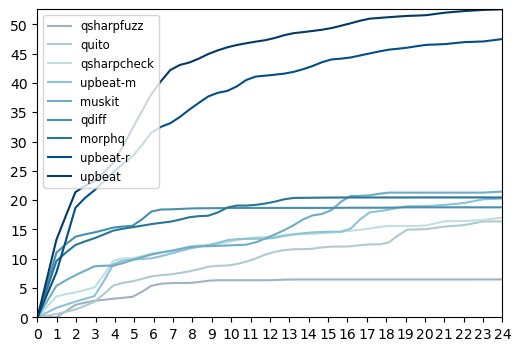

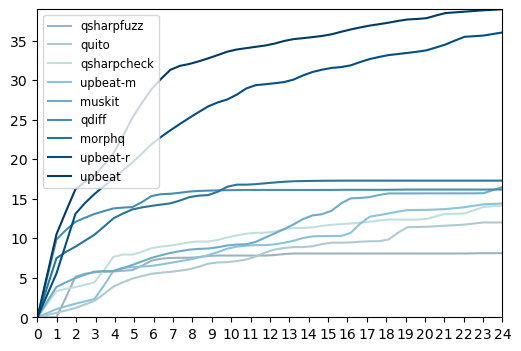

In [11]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline, interp1d

from Fuzzing.calculate_code_coverage import calculate_coverage

color_list = ['#9EB3C2', '#AFCAD0', '#C0E0DE', '#8BC3D9', '#6EACC7', '#468FAF', '#297596', '#014F86', '#013A63']
tool_list = ['qsharpfuzz', 'quito', 'qsharpcheck', 'upbeat-m', 'muskit', 'qdiff', 'morphq', 'upbeat-r', 'upbeat']
# marker_list = [',', 'o', '^', 'v', 'D', '<', '>', 'p', '*']

def draw_one_line(y, label, color):
    x = range(0, 25)
    x_list = np.linspace(0, 24, 50)
    f = interp1d(x, y, kind='linear')
    y_list = f(x_list)
    plt.plot(x_list, y_list, label=label, color=color)

input_folder = "../data/experiment/cov-result-origin/"
output_folder = "../data/experiment/cov-result-calculated/"
# for input_file in os.listdir(input_folder):
#     print("processing "+input_file)
#     calculate_coverage(input_folder+input_file, output_folder+input_file)
line_cov_list, block_cov_list = [], []
for tool, color in zip(tool_list, color_list):
    line_cov, block_cov = [0.0], [0.0]
    output_file = tool+".txt"
    # print("drawing "+output_file)
    with open(output_folder+output_file, "r") as f:
        lines = f.readlines()
    for line in lines:
        if len(line) == 0:
            continue
        block_cov.append(float(line.split(" ")[1]))
        line_cov.append(float(line.split(" ")[2]))
    line_cov_list.append(line_cov)
    block_cov_list.append(block_cov)
plt.figure(figsize=(6, 4))
for line_cov, tool, color in zip(line_cov_list, tool_list, color_list):
    draw_one_line(line_cov, tool, color)
plt.legend(fontsize='small')
plt.xticks(np.arange(0, 25, 1))
plt.yticks(np.arange(0, 60, 5))
plt.margins(x=0, y=0)
# plt.tight_layout()
plt.show()
plt.figure(figsize=(6, 4))
for block_cov, tool, color in zip(block_cov_list, tool_list, color_list):
    draw_one_line(block_cov, tool, color)
plt.legend(fontsize='small')
plt.xticks(np.arange(0, 25, 1))
plt.yticks(np.arange(0, 45, 5))
plt.margins(x=0, y=0)
# plt.tight_layout()
plt.show()

In [12]:
from tabulate import tabulate

regex = r"can be detected by (.*)"
lang_results, diff_results = {}, {}
lang_dir = "../data/experiment/anomalies-lang/"
for f in os.listdir(lang_dir):
    with open(lang_dir+f) as fi:
        first_line = fi.readline()
    # print("first_line:"+first_line)
    match = re.search(regex, first_line)
    tool = match.group(1)
    if tool in lang_results:
        lang_results[tool] += 1
    else:
        lang_results[tool] = 1
print(tabulate(lang_results.items(), headers=["Tool", "#Anomalies via language-level test"]))
print("\n")
abl_dir = "../data/experiment/anomalies-diff/"
for f in os.listdir(abl_dir):
    with open(abl_dir+f) as fi:
        first_line = fi.readline()
    match = re.search(regex, first_line)
    tool = match.group(1)
    if tool in diff_results:
        diff_results[tool] += 1
    else:
        diff_results[tool] = 1
print(tabulate(diff_results.items(), headers=["Tool", "#Anomalies via differential testing"]))

Tool                            #Anomalies via language-level test
----------------------------  ------------------------------------
upbeat                                                           2
qdiff&morphq&upbeat-r&upbeat                                     1
upbeat-r&upbeat                                                  2
upbeat-r                                                         1
qsharpfuzz                                                       1
upbeat-m&upbeat                                                  1


Tool                            #Anomalies via differential testing
----------------------------  -------------------------------------
upbeat                                                            3
qdiff&morphq&upbeat-r&upbeat                                      1
qsharpfuzz&upbeat                                                 2
upbeat-r&upbeat                                                   1
upbeat-m                                              

#### 3.3 Results for RQ3

The Upbeat components all positively contribute to the bugexposing capability of the framework. Run the following two cells to observe the ablation results.

In [13]:
abl_results = {}
abl_dir = "../data/experiment/ablation-study/"
for f in os.listdir(abl_dir):
    with open(abl_dir+f) as fi:
        first_line = fi.readline()
    match = re.search(regex, first_line)
    tool = match.group(1)
    if tool in abl_results:
        abl_results[tool] += 1
    else:
        abl_results[tool] = 1
print(tabulate(abl_results.items(), headers=["Tool", "#Bugs"]))

Tool               #Bugs
---------------  -------
upbeat                 1
upbeat-b&upbeat        3
upbeat-a&upbeat        6


#### 3.4 Results for RQ4

Upbeat is capable of extracting the majority of constraints from both source code and API documents with high accuracy. Run the following two cells to observe the extraction results.

In [14]:
import json
from tabulate import tabulate


def get_rate(num1: int, num2: int):
    if num2 == 0:
        return 0.0
    else:
        return num1 / num2

def convert_to_percent(n):
    n = round(n, 2)
    # print("n:",n)
    return "%.0f%%" % (n * 100)

def calculate(d: dict):
    classical_id, classical_ex, quantum_id, quantum_ex = 0.0, 0.0, 0.0, 0.0
    classical_id_total, classical_ex_total, quantum_id_total, quantum_ex_total = 0, 0, 0, 0
    for namespace, properties in d.items():
        classical_id += get_rate(properties["classical-identified"], properties["classical-id-total"])
        classical_ex += get_rate(properties["classical-extracted"], properties["classical-ex-total"])
        quantum_id += get_rate(properties["quantum-identified"], properties["quantum-id-total"])        
        quantum_ex += get_rate(properties["quantum-extracted"], properties["quantum-ex-total"])
        if properties["classical-id-total"] != 0:
            classical_id_total += 1
        if properties["classical-ex-total"] != 0:
            classical_ex_total += 1
        if properties["quantum-id-total"] != 0:
            quantum_id_total += 1
        if properties["quantum-ex-total"] != 0:
            quantum_ex_total += 1
    # print("quantum_extracted:", quantum_ex)
    return convert_to_percent(classical_id / classical_id_total), convert_to_percent(classical_ex / classical_ex_total), \
           convert_to_percent(quantum_id / quantum_id_total), convert_to_percent(quantum_ex / quantum_ex_total)

with open("../data/experiment/constraint-extraction/source-code.json") as f1:
    code_dict = json.load(f1)
code_result = calculate(code_dict)
tab = [("Source Code", "classical", code_result[0], code_result[1]), ("", "quantum", code_result[2], code_result[3])]
with open("../data/experiment/constraint-extraction/api-document.json") as f2:
    doc_dict = json.load(f2)
doc_result = calculate(doc_dict)
tab.append(("API Document", "classical", doc_result[0], doc_result[1]))
tab.append(("", "quantum", doc_result[2], doc_result[3]))
print(tabulate(tab, headers=["Source", "Type", "Recall", "Precision"]))

Source        Type       Recall    Precision
------------  ---------  --------  -----------
Source Code   classical  100%      93%
              quantum    100%      96%
API Document  classical  80%       81%
              quantum    90%       84%
